### Open this notebook from google drive
Go to "Edit" -> "Notebook settings" and enable **GPU**

In [1]:
!nvidia-smi

Sun Aug 23 12:15:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

 **Connect and authorize google drive with google colab**

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
pwd

'/content'

**go to our project direcotry in google drive:**

In [4]:
%cd gdrive/My\ Drive/spectrum_detector_v1
!ls

/content/gdrive/My Drive/spectrum_detector_v1
batch_train.ipynb     DL_trainset	     mat	    utils.py
checkpoints	      EEG		     __pycache__
detector.ipynb	      generate_images_v2.py  saved_models
detector_train.ipynb  logs		     train_subj.py


# Start my python code here

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print ('tf:', tf.__version__)
import time
from numpy import save, load
from generate_images_v2 import prepare_one_dataset, plotbars, xloc2binaryvec

# sklearn for PR and ROC curves
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from utils import normalize_matrix_1, plot1bar
from utils import plot_loss, plot_metrics, shuffle_trainset
from scipy.io import loadmat, savemat

tf: 2.3.0


In [ ]:
#%% load saved data (.mat) from MATLAB
subj = 's21'
# (1)train set:
# filename1 = 'EEG/SNR3D_set_s1.mat'
filename1 = 'DL_trainset/AVG_ram100/' + subj + '.mat'
file = loadmat(filename1)
data1 = file['SNR3D_arr']
 
# (2) dev set:
# AVG_spectrum_s1 = 'EEG/SNR3D_spectrum_s1.mat'
AVG_spectrum_s1 = 'DL_trainset/AVG96/' + subj + '.mat'
file = loadmat(AVG_spectrum_s1)
data1_dev = file['SNR3D']
print('data1_dev:', data1_dev.shape)

# check shape of INPUT data
r, c = data1.shape
for i in range(c):
    print(data1[0,i].shape)

data1_dev: (96, 60, 120)
(100, 60, 120)
(100, 60, 120)
(100, 60, 120)
(100, 60, 120)
(100, 60, 120)


In [ ]:
#%% orginal labels -> binary labels
labels_full= [4, 6, 27, 33, 35, 37, 39, 43, 45, 66, 72, 76, 78, 99,105,111,117]
labels_subset = [6, 33, 37, 39, 43, 66, 72, 78, 99, 117] # (1)
labels_subset2= [6, 33, 37, 39, 43, 45, 66, 72, 76, 78, 99, 117] # (2)
labels_subset3= [6, 33, 35, 37, 39, 43, 45, 66, 72, 76, 78, 99, 117] # (3)

# choose one annotation from above !
labels_2use = labels_subset



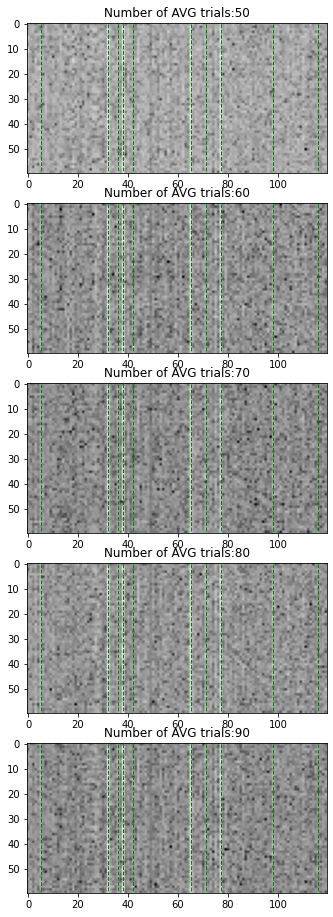

In [ ]:
labels_org = np.array(labels_2use)-1 # python starts from 0
labels_bi = xloc2binaryvec(labels_org) # binary code label: 1 and 0  

# plot first num sample of train set
num = 5 # ntrials = [50, 60, 70, 80, 90]
plt.figure(figsize=(16, 16))
for i in range(num):
    # plot the sample
    images_num = data1[0,i][0]
    plt.subplot(num,1,i+1)
    plt.imshow(images_num, cmap='gray')
    plot1bar(labels_org)
    plt.title('Number of AVG trials:{}'.format((i+5)*10))

In [ ]:
#%% prepare {x_train, y_train, x_test, y_test}
# option B: use AVG- [50, 60, 70, 80, 90] trials for train
x_train = np.concatenate((data1[0,0],data1[0,1],data1[0,2],data1[0,3],data1[0,4]), axis=0)
# dev set (1):
#x_test_100tr = data1_dev[-1] # AVG 100 trials
#x_test = np.reshape(x_test_100tr, (1, x_test_100tr.shape[0], x_test_100tr.shape[1]))
# dev set (2):
x_test = data1_dev # (96, 60, 120)

# normalize X to [0 - 1] 
x_train = normalize_matrix_1(x_train)
x_test =  normalize_matrix_1(x_test)

# repeating Y (labels_bi) the number of times given by number of samples  
y_train = np.tile(labels_bi, (len(x_train),1))# (10k,120)
y_test  = np.tile(labels_bi, (len(x_test),1))# (100,120)

# shuffle [x_train, y_train] 100x along the dimenstion of frequency '1-120' 
x_train, y_train = shuffle_trainset(x_train, y_train)


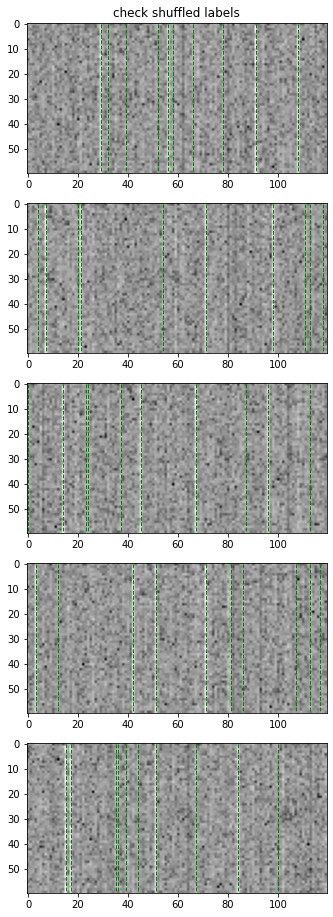

In [ ]:
#%% check shuffled labels: plot m samples with shuffled labels
m = 5
n_start = 100
fig = plt.figure(figsize=(16, 16))
for i in range(m):
    image = x_train[n_start+i]
    label = np.where(y_train[n_start+i] > 0.5)[0] # len() == 6 
    plt.subplot(m,1,i+1)
    plt.imshow(image, cmap='gray')
    if i==0:
        plt.title('check shuffled labels')
    plot1bar(label)

In [ ]:
#%% define a model
tf.keras.backend.clear_session()
def create_model():
    # (C) CNN model (~2 conv layers): ~ 230k paras
    inputs = keras.Input(shape=(60, 120, 1)) # 1 is needed here to keep the same dim with next conv2D layer
    x = layers.experimental.preprocessing.Rescaling(1.0 / 1)(inputs)
    x = layers.Conv2D(filters=8, kernel_size=(3, 3), padding='same', activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(1, 1),padding='same')(x) # stride =1, not =3 be default
    x = layers.Dropout(.2)(x)
    x = layers.Conv2D(filters=4, kernel_size=(3, 3), padding='same', activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same')(x) # stride =1, not =2 be default
    x = layers.Dropout(.2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1024, activation="relu")(x) # it does not further improve!
    outputs = layers.Dense(120, activation= 'sigmoid')(x)
    model = keras.Model(inputs, outputs)

    loss = tf.keras.losses.BinaryCrossentropy()
    # optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, 
                                         beta_1=0.9, beta_2=0.999, epsilon=1e-07)
    
    # METRICS = [
    #       keras.metrics.TruePositives(name='tp'),
    #       keras.metrics.FalsePositives(name='fp'),
    #       keras.metrics.TrueNegatives(name='tn'),
    #       keras.metrics.FalseNegatives(name='fn'), 
    #       keras.metrics.BinaryAccuracy(name='accuracy'),
    #       keras.metrics.Precision(name='precision'),
    #       keras.metrics.Recall(name='recall'),
    #       keras.metrics.AUC(name='auc'),
    #       ]
    
    METRICS = [ 
          keras.metrics.BinaryAccuracy(name='accuracy'),
          keras.metrics.Precision(name='precision'),
          keras.metrics.Recall(name='recall'),
          keras.metrics.AUC(name='auc', curve='PR'), # curve='ROC' by default
          ]
    
    model.compile(
        optimizer= optimizer,
        loss=loss,
        metrics= METRICS,
        )
    
    return model

In [ ]:
#%% Build a model
# Create a basic model instance
model = create_model() 
# show model
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 60, 120, 1)]      0         
_________________________________________________________________
rescaling (Rescaling)        (None, 60, 120, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 60, 120, 8)        80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 120, 8)        0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 120, 8)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 120, 4)        292       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 120, 4)       

Epoch 1/20
  1/196 [..............................] - ETA: 0s - loss: 0.7116 - accuracy: 0.5029 - precision: 0.0843 - recall: 0.5035 - auc: 0.0843WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
196/196 [==============================] - ETA: 0s - loss: 0.3013 - accuracy: 0.9139 - precision: 0.0843 - recall: 0.0034 - auc: 0.0893
Epoch 00001: val_auc improved from -inf to 0.15693, saving model to checkpoints/my_ckpt
196/196 [==============================] - 10s 50ms/step - loss: 0.3013 - accuracy: 0.9139 - precision: 0.0843 - recall: 0.0034 - auc: 0.0893 - val_loss: 0.4413 - val_accuracy: 0.9167 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.1569
Epoch 2/20
195/196 [============================>.] - ETA: 0s - loss: 0.2312 - accuracy: 0.9277 -

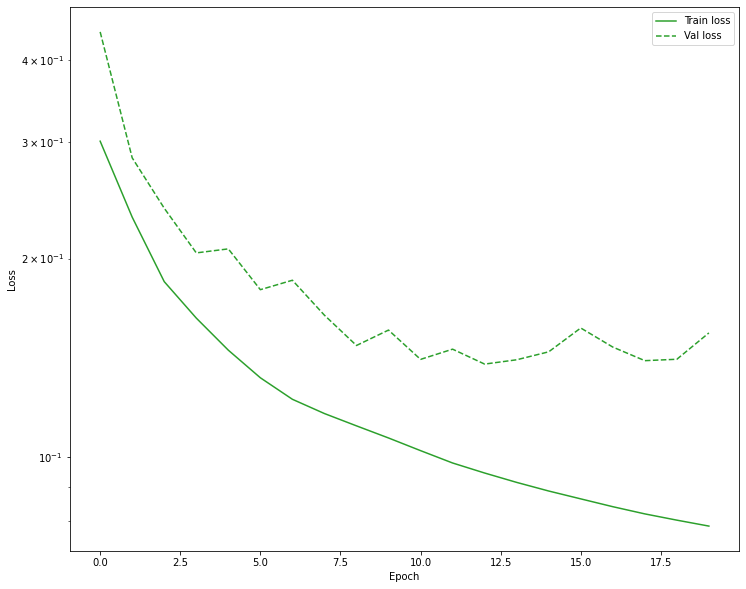

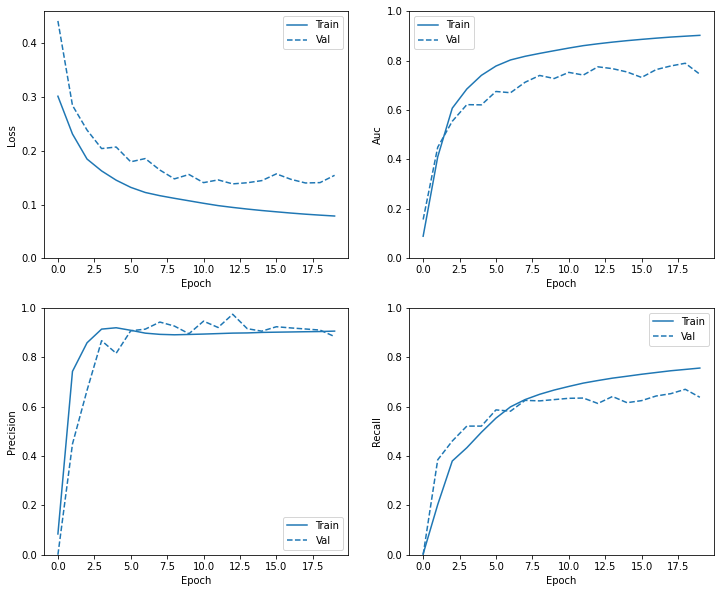

In [ ]:
#%% train
N_epoch = 20
# (callback 1) for using TensorBoard
callback_log = [keras.callbacks.TensorBoard(log_dir='./logs')] 
# Launch TensorBoard from the command line (1st cd: folder of this proj) 
# in cmd type: tensorboard --logdir logs

# (callback 2) Create a callback that saves the model's weights
# only model that achieves larger 'val_auc' is saved.
checkpoint_path = "checkpoints/my_ckpt"
callback_cp = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 monitor='val_auc',
                                                 mode='max',
                                                 save_best_only=True,
                                                 verbose=1)
start_time = time.time()
# Train the model from Numpy data input
history = model.fit(x_train, y_train, 
                    validation_data= (x_test, y_test), 
                    batch_size= 256, 
                    epochs=N_epoch, 
                    callbacks=[callback_log, callback_cp])

print('elapsed_time:',  time.time() - start_time) # =203 s for 100 epochs

#%% plot learning curves - [loss, AUC, etc.]
plt.figure(figsize=(12, 10)) 
plot_loss(history, "loss", 2)
# plot metrics over epochs
plt.figure(figsize=(12, 10))    
plot_metrics(history)

Text(0.5, 1.0, 'Mean prediction')

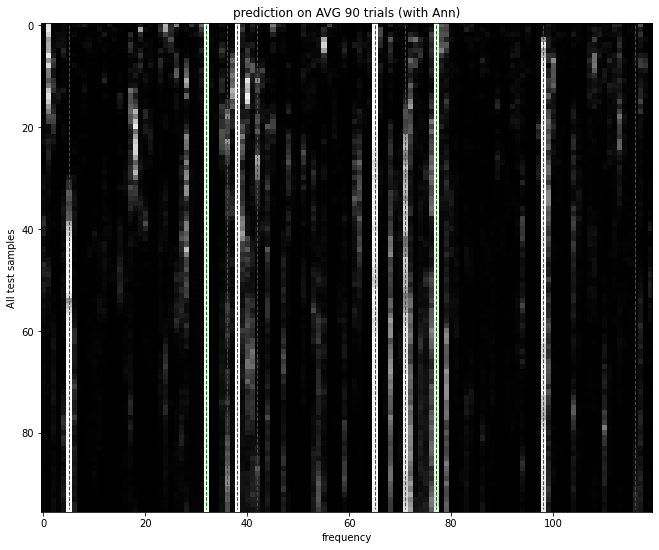

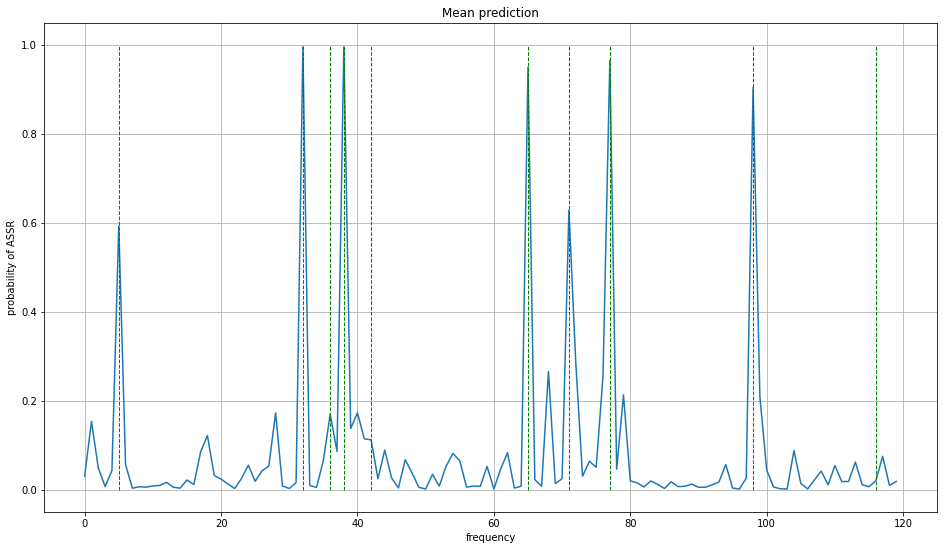

In [ ]:
#%% test the latest trained_model on a subset of the train set: AVG-90
predictions = model.predict(x_test)
predictions_mean = np.mean(predictions, axis = 0)

labels2plt = labels_org

plt.figure(figsize=(16, 9))
plt.imshow(predictions, cmap='gray')
plot1bar(labels2plt, L=96)
plt.xlabel('frequency')
plt.ylabel('All test samples')
plt.title('prediction on AVG 90 trials (with Ann)')

plt.figure(figsize=(16, 9))
plt.plot(predictions_mean)
plot1bar(labels2plt, L=2)
plt.grid(True)
plt.xlabel('frequency')
plt.ylabel('probability of ASSR')
plt.title('Mean prediction')

## Save the best trained model

**Evaluate the saved 'best model weights' from callback_func**

In [ ]:
# Create a basic model instance
model = create_model() 
# Display the model's architecture
model.summary()
# Evaluate the initial model
loss, acc,_,_,_ = model.evaluate(x_test, y_test, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100*acc))

# Re-load the model weights from the saved checkpoints
model.load_weights(checkpoint_path) # Loads the weights
# Evaluate the saved model
loss, acc,_,_,_ = model.evaluate(x_test, y_test, verbose=2)
print("saved model, accuracy: {:5.2f}%".format(100*acc))


#%% save the entire trained model (not only weights in checkpoints)
# choose the path for saving 
save_dir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    
model_name = subj +'_best_trained_model.h5'
model_path = os.path.join(save_dir, model_name)  
model.save(model_path)
print('Saved trained model at %s ' % model_path)    


Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 60, 120, 1)]      0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 60, 120, 1)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 120, 8)        80        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 60, 120, 8)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 120, 8)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 120, 4)        292       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 60, 120, 4)       

Text(0.5, 1.0, 'Mean prediction')

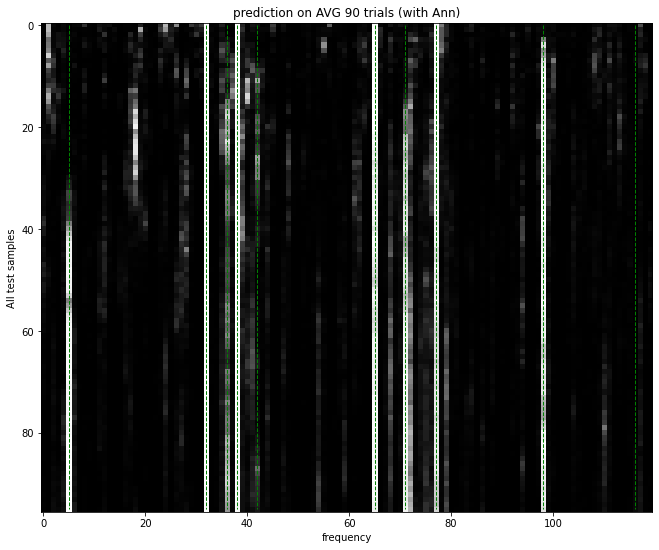

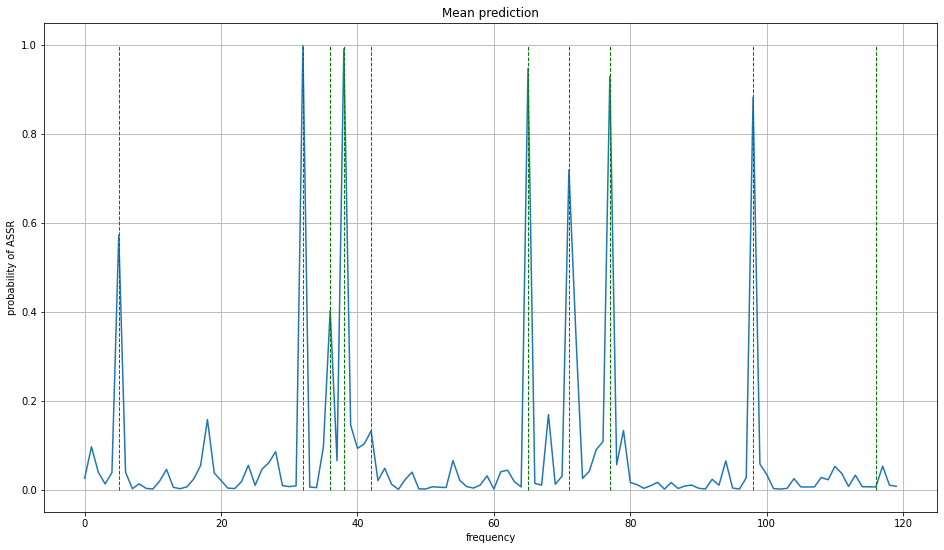

In [ ]:
#%% test the best_trained_model on x_test (AVG-100 trials) of day1 EEG
predictions = model.predict(x_test)
predictions_mean = np.mean(predictions, axis = 0)

labels2plt = labels_org

plt.figure(figsize=(16, 9))
plt.imshow(predictions, cmap='gray')
plot1bar(labels2plt, L=96)
plt.xlabel('frequency')
plt.ylabel('All test samples')
plt.title('prediction on AVG 90 trials (with Ann)')

plt.figure(figsize=(16, 9))
plt.plot(predictions_mean)
plot1bar(labels2plt, L=2)
plt.grid(True)
plt.xlabel('frequency')
plt.ylabel('probability of ASSR')
plt.title('Mean prediction')
